In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/kvasir-dataset.rar", outdir="/content/")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
from keras.regularizers import l1,l2
from keras.models import Sequential
from keras.layers import Dropout , BatchNormalization , Flatten , MaxPooling2D , Activation , Dense , Conv2D , InputLayer , MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


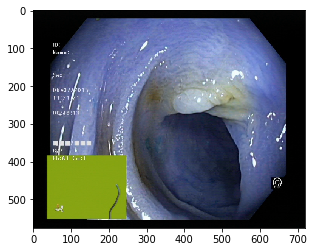

In [9]:
DATADIR_train = '/content/kvasir-dataset/kvasir-dataset-v2/train'
CATEGORIES= ['dyed-lifted-polyps' , 'dyed-resection-margins' , 'esophagitis' , 'normal-cecum' , 'normal-pylorus' , 'normal-z-line', 'polyps', 'ulcerative-colitis']
 
for category in CATEGORIES:
    path = os.path.join(DATADIR_train,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array , cmap='gray')
        break
    break    

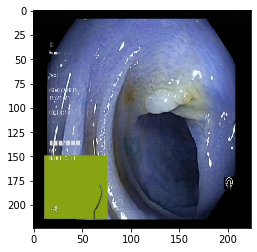

In [10]:
# to normalise the data (images)
IMG_SIZE=224
new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array , cmap='gray')
plt.show()

In [0]:
training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR_train,category)
        class_num = CATEGORIES.index(category)  # giving number to each category or mapping each category to a no. 
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
                training_data.append([new_array , class_num])
            except Exception as e:
                pass
        
        
create_training_data() 

In [0]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
     

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_train = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,3)

X_train = X_train.astype("float32")/255 
X_test = X_test.astype("float32")/255

y_train = keras.utils.to_categorical(y_train , num_classes=8)
y_test = keras.utils.to_categorical(y_test , num_classes=8)

In [31]:
IMAGE_SIZE = [224, 224]

train_path = '/content/kvasir-dataset/kvasir-dataset-v2/train'
valid_path = '/content/kvasir-dataset/kvasir-dataset-v2/test'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/kvasir-dataset/kvasir-dataset-v2/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
VGG = model.fit(X_train,y_train , epochs=30 , batch_size=32 , validation_data=(X_test,y_test))

Train on 6000 samples, validate on 2000 samples
Epoch 1/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.8334 - acc: 0.6835 - val_loss: 0.6681 - val_acc: 0.7345
Epoch 2/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.4522 - acc: 0.8213 - val_loss: 0.4654 - val_acc: 0.8225
Epoch 3/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.3103 - acc: 0.8783 - val_loss: 0.5591 - val_acc: 0.7845
Epoch 4/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.3133 - acc: 0.8865 - val_loss: 0.5680 - val_acc: 0.8015
Epoch 5/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1920 - acc: 0.9293 - val_loss: 0.5299 - val_acc: 0.8185
Epoch 6/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1524 - acc: 0.9450 - val_loss: 0.4632 - val_acc: 0.8390
Epoch 7/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1146 - acc: 0.9643 - val_loss: 0.4719 - val_acc: 0.8280
Epoch 8

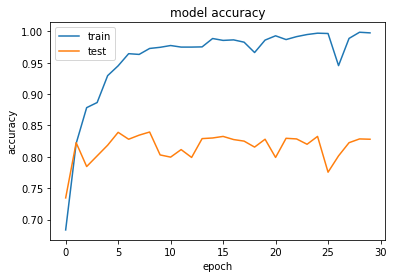

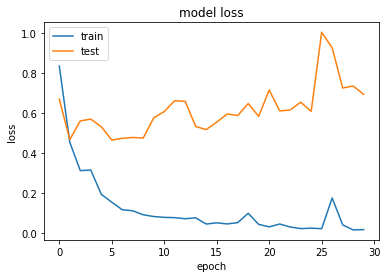

In [35]:
plt.plot(VGG.history['acc'])
plt.plot(VGG.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
 

plt.plot(VGG.history['loss'])
plt.plot(VGG.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show() 


# Data augmentation on VGG16 model

In [15]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/kvasir-dataset/kvasir-dataset-v2/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/kvasir-dataset/kvasir-dataset-v2/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8000 images belonging to 8 classes.
Found 8000 images belonging to 8 classes.


In [18]:
VGG16_history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

Epoch 1/30
250/250 [==============================] - 330s 1s/step - loss: 0.3922 - acc: 0.8654 - val_loss: 0.3653 - val_acc: 0.8592
Epoch 2/30
250/250 [==============================] - 321s 1s/step - loss: 0.3347 - acc: 0.8793 - val_loss: 0.3244 - val_acc: 0.8951
Epoch 3/30
250/250 [==============================] - 324s 1s/step - loss: 0.3733 - acc: 0.8716 - val_loss: 0.3356 - val_acc: 0.8839
Epoch 4/30
250/250 [==============================] - 325s 1s/step - loss: 0.3035 - acc: 0.8821 - val_loss: 0.2366 - val_acc: 0.9119
Epoch 5/30
250/250 [==============================] - 325s 1s/step - loss: 0.2995 - acc: 0.8934 - val_loss: 0.3186 - val_acc: 0.8738
Epoch 6/30
250/250 [==============================] - 324s 1s/step - loss: 0.3114 - acc: 0.8831 - val_loss: 0.2275 - val_acc: 0.9120
Epoch 7/30
250/250 [==============================] - 324s 1s/step - loss: 0.2843 - acc: 0.8966 - val_loss: 0.1782 - val_acc: 0.9289
Epoch 8/30
250/250 [==============================] - 323s 1s/step - 

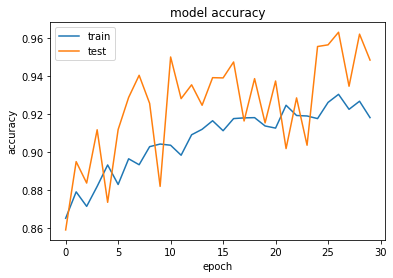

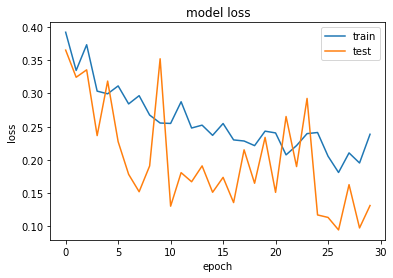

In [42]:
# plt.figure(figsize=(12,6))
plt.plot(VGG16_history.history['acc'])
plt.plot(VGG16_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
 
# plt.figure(figsize=(12,6))
plt.plot(VGG16_history.history['loss'])
plt.plot(VGG16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show() 
